# Project Overview

Tanzania, as a developing country, struggles with providing clean water to its population of over 57,000,000. There are many waterpoints already established in the country, but some are in need of repair while others have failed altogether.

Can you predict which water pumps are faulty?

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

Build a classifier to predict the condition of a water well, using information about the sort of pump, when it was installed, etc. Note that this is a ternary classification problem.

<a href="https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/">Tanzanian Water Well Data</a>
 
This dataset is part of an active competition until April 31, 2021!



## Import packages

In [1]:
import pandas as pd
import numpy as np
import sys
import zipfile
import folium
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ParameterGrid
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from mlxtend.classifier import StackingClassifier

In C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Sin City

## Data

#### Import Data

In [2]:
X = pd.read_csv("../../references/training_set_values.csv", index_col = 'id')

In [3]:
y = pd.read_csv("../../references/training_set_labels.csv", index_col = 'id')['status_group']

In [4]:
unlabeled_df = pd.read_csv("../../references/test_set_values.csv", index_col = 'id')

#### Feature info

<a href="https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/">Link to information about features</a>

In [5]:
# amount_tsh - Total static head (amount water available to waterpoint)
# date_recorded - The date the row was entered - do not include
# funder - Who funded the well
# gps_height - Altitude of the well
# installer - Organization that installed the well
# longitude - GPS coordinate - do not include
# latitude - GPS coordinate - do not include
# wpt_name - Name of the waterpoint if there is one
# num_private -
# basin - Geographic water basin
# subvillage - Geographic location
# region - Geographic location
# region_code - Geographic location (coded)
# district_code - Geographic location (coded)
# lga - Geographic location
# ward - Geographic location
# population - Population around the well
# public_meeting - True/False - ?
# recorded_by - Group entering this row of data
# scheme_management - Who operates the waterpoint
# scheme_name - Who operates the waterpoint
# permit - If the waterpoint is permitted
# construction_year - Year the waterpoint was constructed
# extraction_type - The kind of extraction the waterpoint uses
# extraction_type_group - The kind of extraction the waterpoint uses
# extraction_type_class - The kind of extraction the waterpoint uses
# management - How the waterpoint is managed
# management_group - How the waterpoint is managed
# payment - What the water costs
# payment_type - What the water costs
# water_quality - The quality of the water
# quality_group - The quality of the water
# quantity - The quantity of water
# quantity_group - The quantity of water
# source - The source of the water
# source_type - The source of the water
# source_class - The source of the water
# waterpoint_type - The kind of waterpoint
# waterpoint_type_group - The kind of waterpoint

### Maps

#### Scatter Plot of Wells

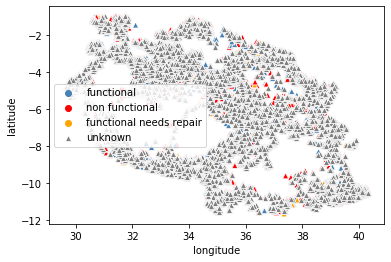

In [6]:
df_loc = X.join(y)[['longitude', 'latitude', 'status_group']]
df_loc = df_loc[df_loc['longitude']!=0]
df_loc.status_group.value_counts()

sns.scatterplot(data=df_loc, x = 'longitude', y = 'latitude', marker = '^', alpha = 1,
                hue = df_loc.status_group.tolist(), palette = ['steelblue', 'red', 'orange'])


test_df_loc = unlabeled_df[['longitude', 'latitude']]
test_df_loc = test_df_loc[test_df_loc['longitude']!=0]
test_df_loc['status_group'] = 'unknown'
sns.scatterplot(data = test_df_loc, x = 'longitude', y = 'latitude', marker= "^", color = 'grey', label = 'unknown');

#### Import shape files for Tanzania

In [7]:
# Uncomment to download shapefiles
# ! wget -P ../../data http://stacks.stanford.edu/file/druid:tn398yw9512/data.zip

In [8]:
# Uncomment to unzip shapefiles
# with zipfile.ZipFile('../../data/data.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/shapefiles')

#### Create GeoDataFrames from Data
Convert crs from 4326 to 3857 (changes latitude and logitude format for plotting)

In [9]:
geo_df = gpd.read_file('../../data/shapefiles/TAN.shp')
geo_df = geo_df.to_crs(epsg = 3857)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [10]:
# Add a geometry column that holds Point objects with lat and long
df_loc['geometry'] = df_loc.apply(lambda x: Point(float(x.longitude), float(x.latitude)), axis=1)
gdf = gpd.GeoDataFrame(df_loc, geometry='geometry')
gdf.crs = "EPSG:4326"
gdf = gdf.to_crs(epsg = 3857)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [11]:
# Add a geometry column that holds Point objects with lat and long
test_df_loc['geometry'] = test_df_loc.apply(lambda x: Point(float(x.longitude), float(x.latitude)), axis=1)
gdf_test = gpd.GeoDataFrame(test_df_loc, geometry='geometry')
gdf_test.crs = "EPSG:4326"
gdf_test = gdf_test.to_crs(epsg = 3857)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


#### Create Folium map to show where Tanzania is

In [12]:
m = folium.Map(location=[-6.3690, 34.8888], zoom_start = 5)
m.choropleth(geo_data=geo_df, fill_color='blue', fill_opacity=0.2, line_opacity=.1)
display(m)

C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
C:\Users\Sin City\anaconda3\envs\learn-env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


#### Geopandas plots with Contextly

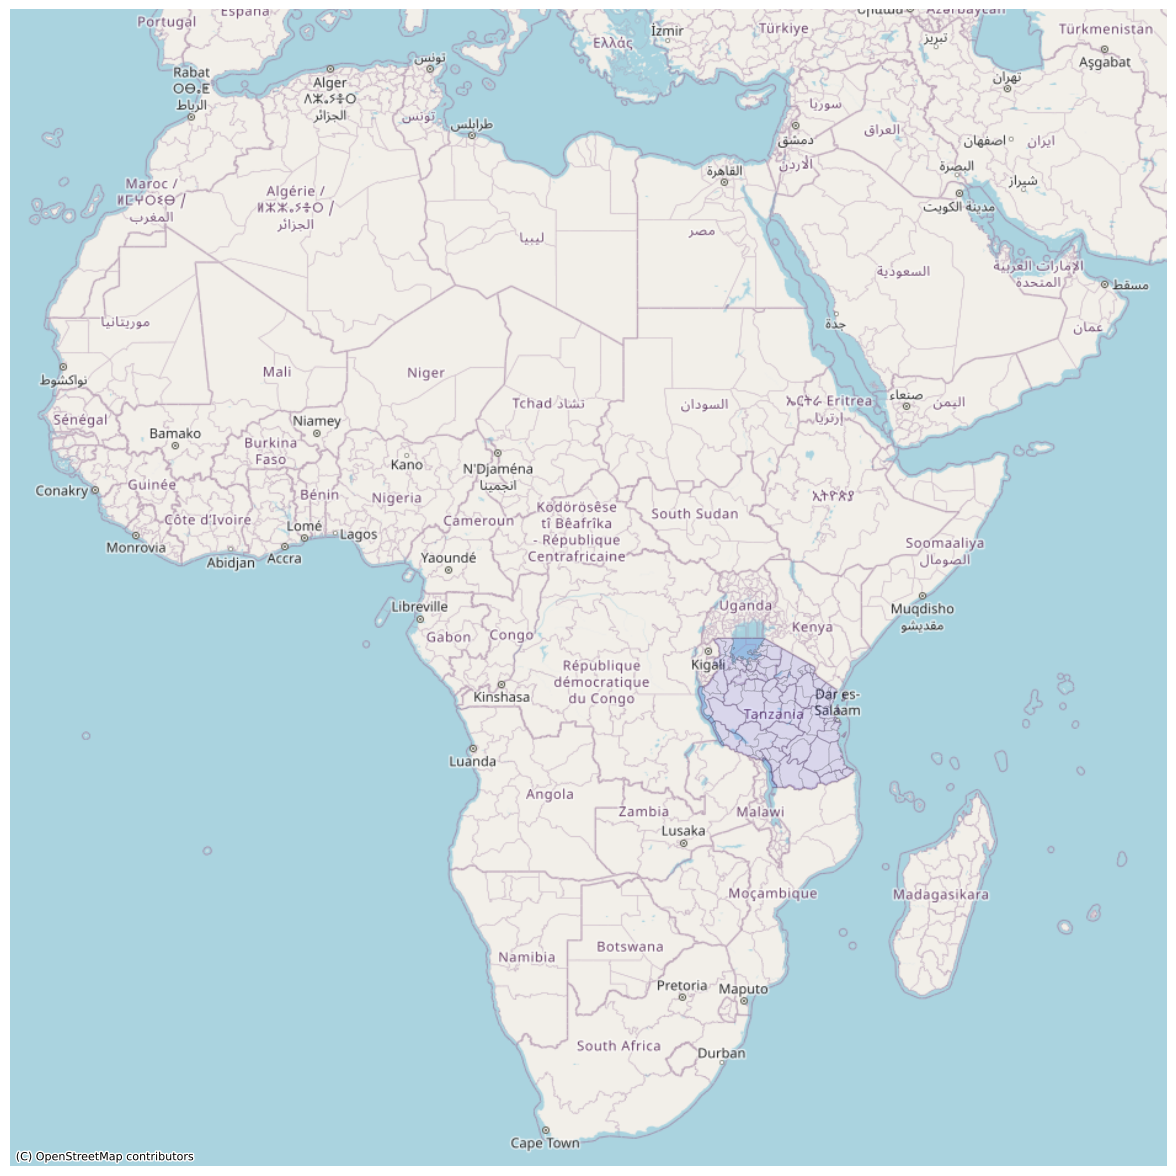

In [13]:
plt.style.use('default')
sns.set_context("paper", font_scale=1.5)

fig, ax = plt.subplots(figsize=(12,12))
geo_df.plot(ax=ax, color = 'blue', edgecolor = 'k', alpha = .1)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-5500000, maxx+2500000)
ax.set_ylim(miny-3000000, maxy+5000000)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik) #source=ctx.providers.OpenStreetMap.Mapnik) lots of styles to choose from
# plt.title('Tanzanian Water Wells')

ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Africa.jpg');

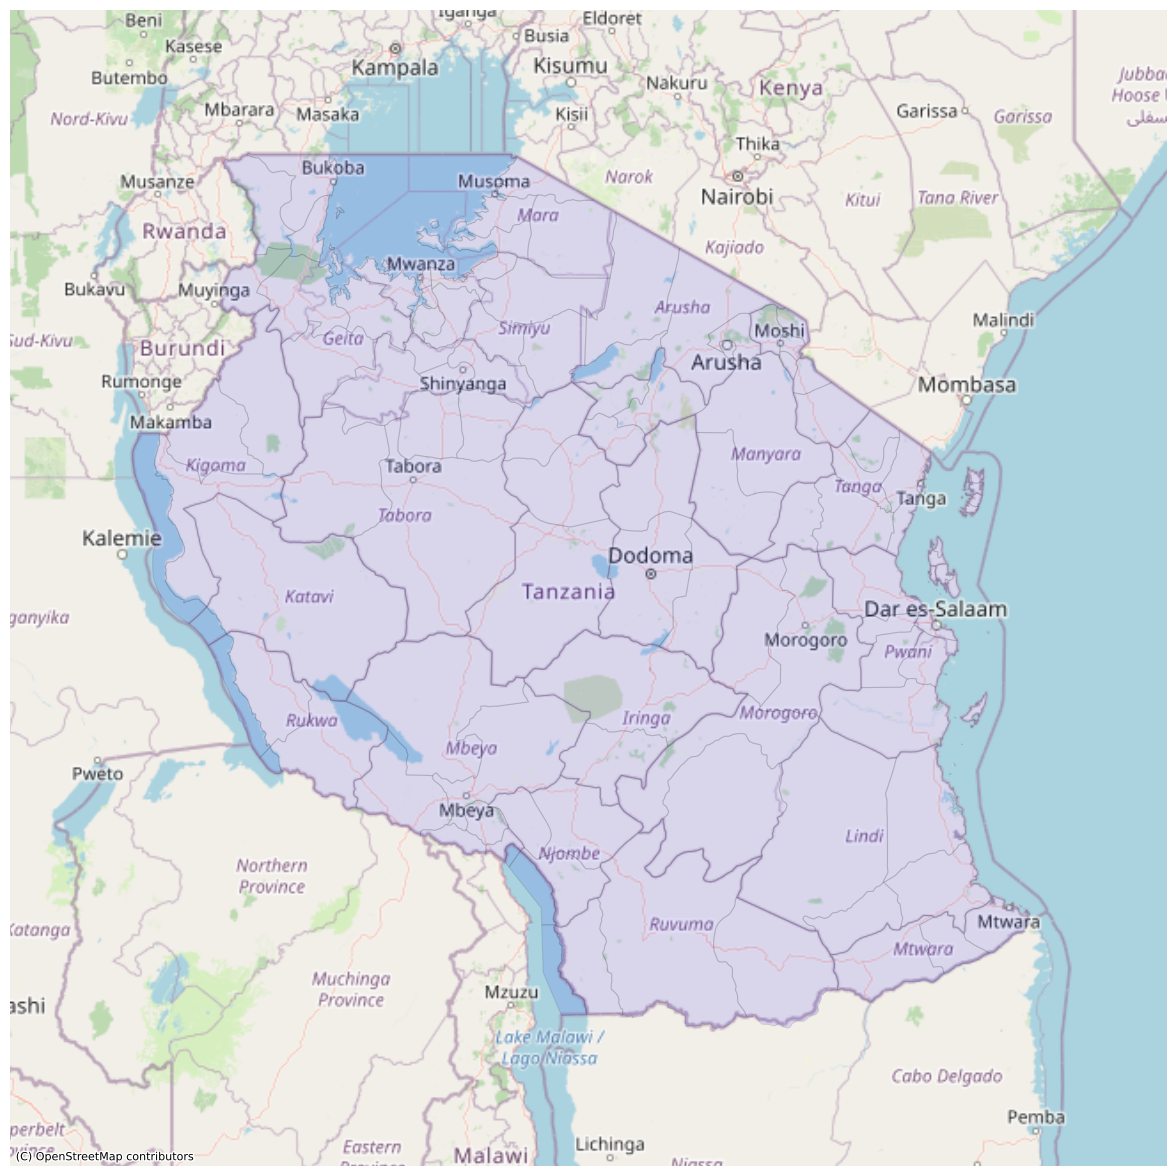

In [14]:
plt.style.use('default')
sns.set_context("paper", font_scale=1.5)

fig, ax = plt.subplots(figsize=(12,12))
geo_df.plot(ax=ax, color = 'blue', edgecolor = 'k', alpha = .1)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-200000, maxx+200000)
ax.set_ylim(miny-200000, maxy+200000)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik) #source=ctx.providers.OpenStreetMap.Mapnik) lots of styles to choose from
# plt.title('Tanzania', fontdict={'fontsize': '50', 'fontweight' : '10', 'color' : 'coral'})

ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Tanzania.jpg', dpi = 300);

#### Add Wells + Status to Plot

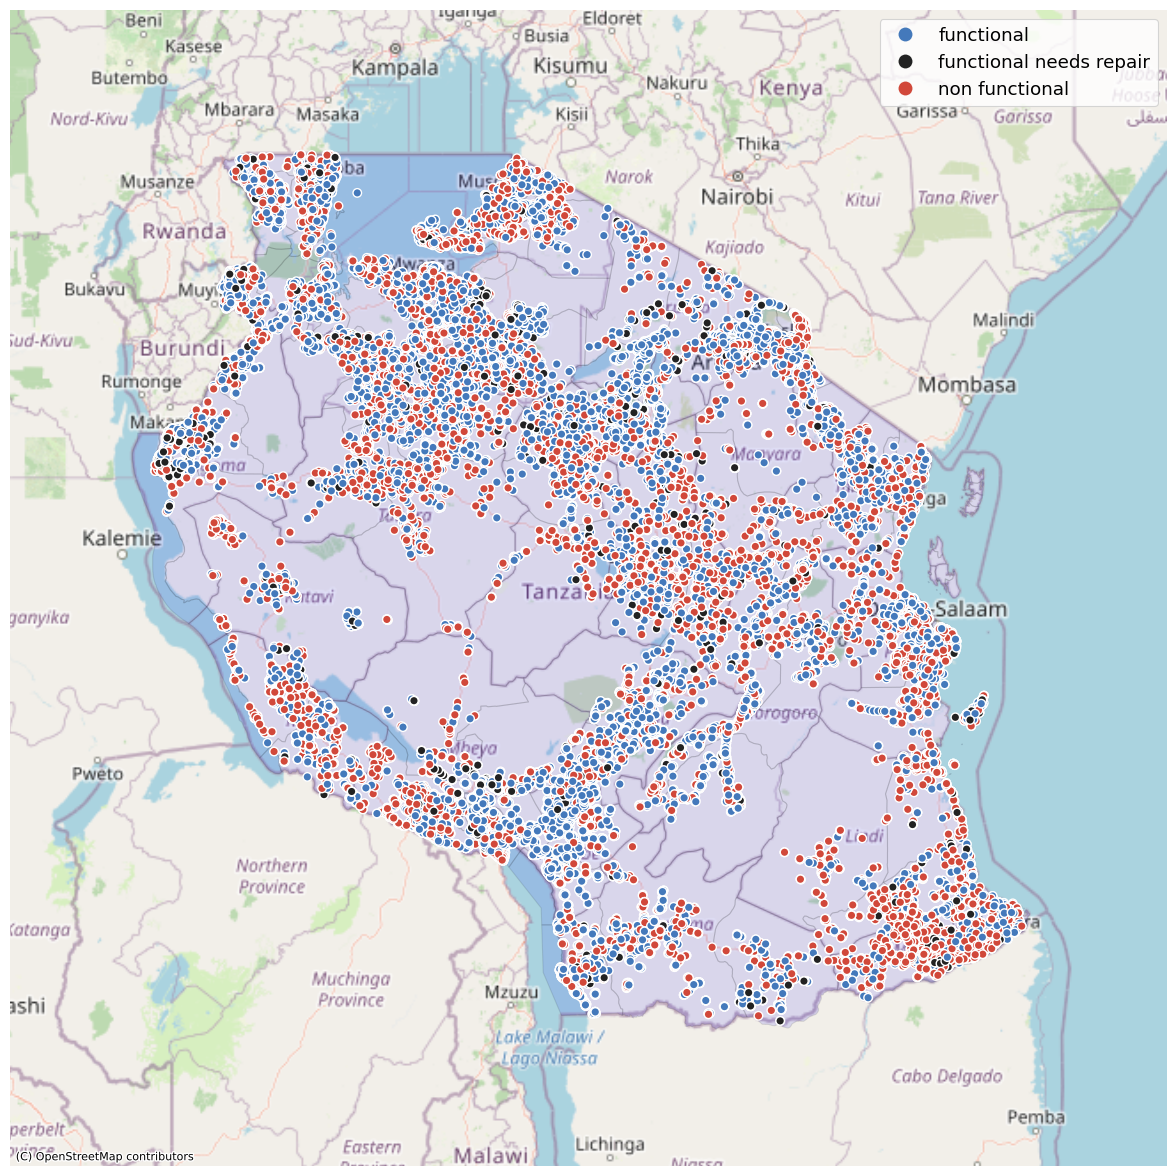

In [15]:
sns.set_context(font_scale=1.5)

fig, ax = plt.subplots(figsize=(12,12))

geo_df.plot(ax=ax, color = 'blue', edgecolor = 'k', alpha = .1)

custom_palette = sns.diverging_palette(250, 15, l=50, center="dark", as_cmap=True)

gdf.plot(ax=ax, column = 'status_group', marker = '.', markersize=150,
         edgecolor = 'white', cmap = custom_palette,
         linewidth=1, legend = True)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-200000, maxx+200000)
ax.set_ylim(miny-200000, maxy+200000)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)#, source=ctx.providers.OpenStreetMap.Mapnik)
# plt.title('Tanzanian Water Wells', fontdict={'fontsize': '50', 'fontweight' : '10', 'color' : 'coral'})

ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Tanzania_train.jpg', dpi = 300);

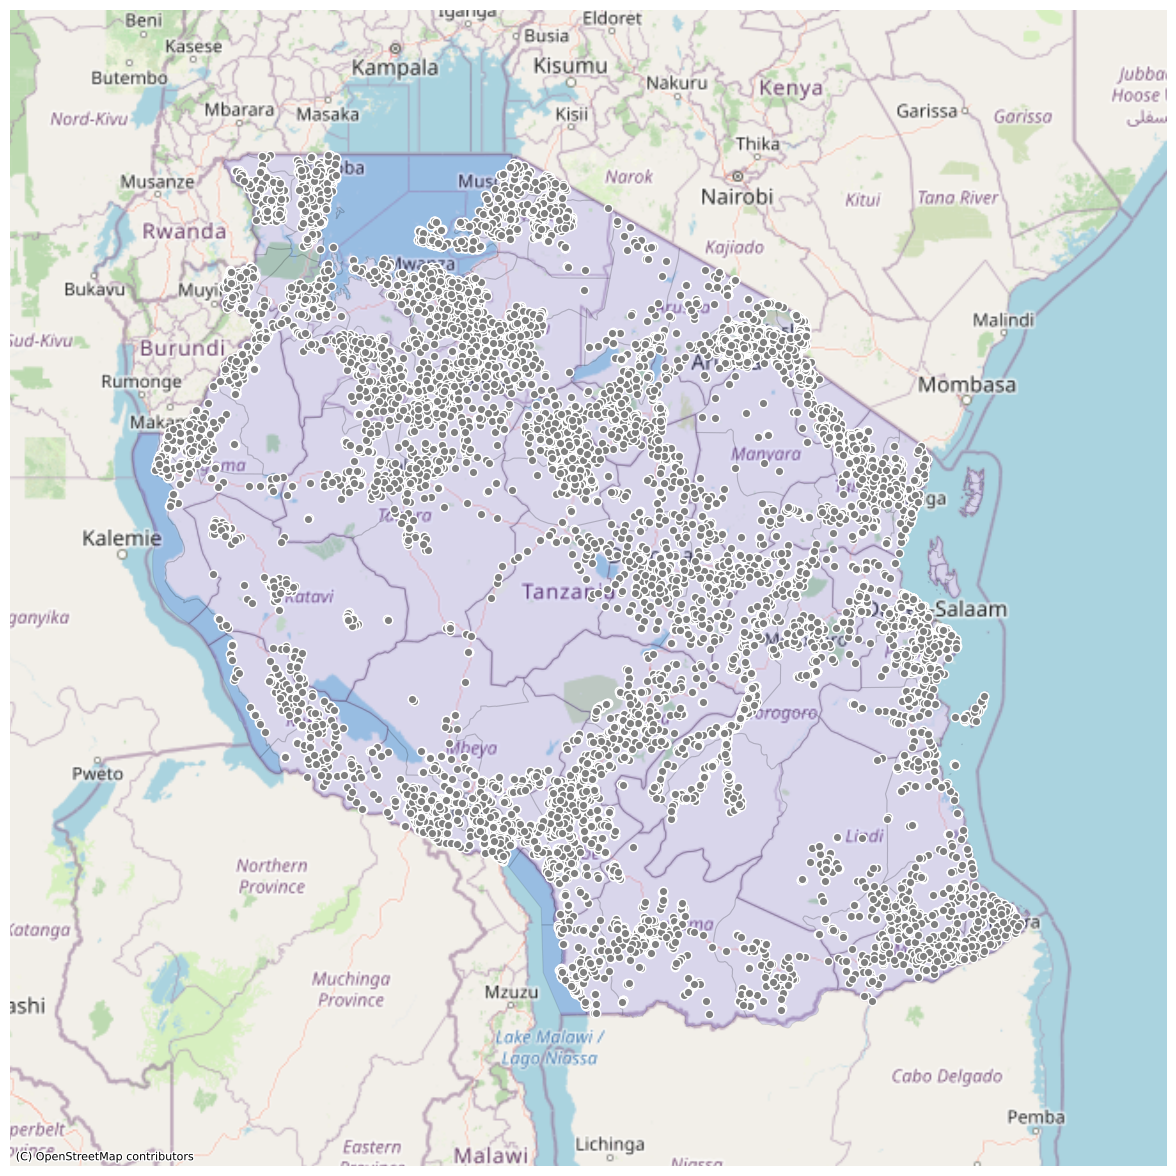

In [16]:
fig, ax = plt.subplots(figsize=(12,12))
geo_df.plot(ax=ax, color = 'blue', edgecolor = 'k', alpha = .1)

gdf_test.plot(ax=ax, marker = '.', markersize=150, color='grey',
              edgecolor = 'white', linewidth=1, legend = True)

minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-200000, maxx+200000)
ax.set_ylim(miny-200000, maxy+200000)

ctx.add_basemap(ax, source = ctx.providers.OpenStreetMap.Mapnik)#, source=ctx.providers.OpenStreetMap.Mapnik)
# plt.title('Tanzanian Water Wells', fontdict={'fontsize': '50', 'fontweight' : '10', 'color' : 'coral'})
ax.set_axis_off()
fig.tight_layout()
plt.savefig('../../reports/figures/Tanzania_test.jpg', dpi = 300);

### Data Cleaning

#### Drop Date and NA and unique identifier columns for now

In [17]:
# X.info()

In [18]:
columns_with_na = ['permit', 'scheme_name', 'scheme_management', 'public_meeting', 'subvillage', 'installer', 'funder']
X.drop(columns_with_na, axis=1, inplace=True)

In [19]:
columns_with_specific_location_and_names = ['ward', 'wpt_name']
X.drop(columns_with_specific_location_and_names, axis=1, inplace=True)

In [20]:
X.drop('date_recorded', axis=1, inplace=True)

### EDA Visuals

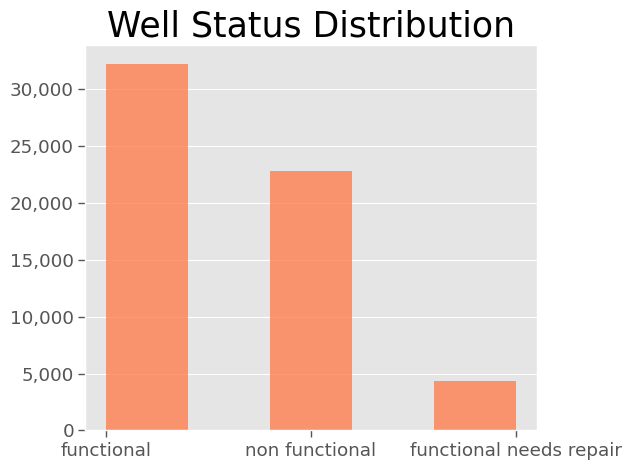

In [21]:
sns.set_context("paper", font_scale=1.5)

plt.style.use('ggplot')

fig, ax = plt.subplots() 
ax.hist(y, alpha = .8, bins = 5, color = 'coral')
ax.set_title('Well Status Distribution', fontdict={'fontsize': '25', 'fontweight' : '30', 'color' : 'black'})
ax.xaxis.grid() # horizontal lines

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

fig.tight_layout()
plt.savefig('../../reports/figures/Well_status_dist.jpg')

## Preprocess Data for Model

#### Train Test Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)

#### Split Data into continuous and categorical

In [23]:
X.dtypes.value_counts()

object     20
int64       6
float64     3
dtype: int64

In [24]:
X_train_cat = X_train.select_dtypes(include='object')
X_train_cont = X_train.select_dtypes(exclude='object')
X_test_cat = X_test.select_dtypes(include='object')
X_test_cont = X_test.select_dtypes(exclude='object')

#### Simple Imputer to fill null numeric values

In [25]:
si = SimpleImputer()
X_train_imp = pd.DataFrame(si.fit_transform(X_train_cont), index = X_train_cont.index, columns = X_train_cont.columns)
X_test_imp = pd.DataFrame(si.transform(X_test_cont), index = X_test_cont.index, columns = X_test_cont.columns)

#### Standard Scaler to scale numeric values

In [26]:
ss = StandardScaler()
X_train_sc = pd.DataFrame(ss.fit_transform(X_train_imp), index = X_train_imp.index, columns = X_train_imp.columns)
X_test_sc = pd.DataFrame(ss.transform(X_test_imp), index = X_test_imp.index, columns = X_test_imp.columns)

#### OneHotEncoder for categorical columns

In [27]:
# X_train_cat.info()

In [28]:
ohe = OneHotEncoder(drop = 'if_binary', sparse = False)
X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train_cat),
                          columns = ohe.get_feature_names(X_train_cat.columns), index = X_train_cat.index)
X_test_ohe = pd.DataFrame(ohe.transform(X_test_cat),
                          columns = ohe.get_feature_names(X_test_cat.columns), index = X_test_cat.index)

#### Join numeric and object DataFrames back together after preprocessing

In [29]:
X_train_fin = X_train_sc.join(X_train_ohe)
X_test_fin = X_test_sc.join(X_test_ohe)
print('Features Count: ', X_train_fin.shape[1])

Features Count:  291


## Modeling

#### Create a Baseline Model

In [30]:
lr = LogisticRegression(max_iter=1000, random_state = 42)
lr.fit(X_train_fin, y_train)

LogisticRegression(max_iter=1000, random_state=42)

#### Score model on training data

In [31]:
# Score on our training data
y_pred = lr.predict(X_train_fin)
print(classification_report(y_train, y_pred)) 

                         precision    recall  f1-score   support

             functional       0.73      0.90      0.81     24161
functional needs repair       0.58      0.12      0.20      3243
         non functional       0.80      0.67      0.72     17146

               accuracy                           0.75     44550
              macro avg       0.70      0.56      0.58     44550
           weighted avg       0.75      0.75      0.73     44550



In [32]:
# Note - This cell takes time to run
# val = cross_val_score(lr, X_train_fin, y_train, cv=5)
# val

#### Score model on testing data

In [33]:
# Score on our testing data
y_pred = lr.predict(X_test_fin)
print(classification_report(y_test, y_pred)) 

                         precision    recall  f1-score   support

             functional       0.73      0.89      0.80      8098
functional needs repair       0.51      0.12      0.19      1074
         non functional       0.78      0.66      0.72      5678

               accuracy                           0.75     14850
              macro avg       0.68      0.56      0.57     14850
           weighted avg       0.74      0.75      0.73     14850



#### Coefficients of Features

In [34]:
coef = pd.DataFrame(lr.coef_, columns = X_test_fin.columns).transpose()

In [35]:
pd.set_option('display.max_rows', 500)
# coef

### Refining our Data

#### Using Smote to Deal with Class Imbalance

In [36]:
y_train.value_counts()

functional                 24161
non functional             17146
functional needs repair     3243
Name: status_group, dtype: int64

In [37]:
print("Before OverSampling, counts of label 'functional needs repair': {}".format(sum(y_train == 'functional needs repair'))) 
print("Before OverSampling, counts of label 'functional': {}".format(sum(y_train == 'functional'))) 
print("Before OverSampling, counts of label 'non functional': {} \n".format(sum(y_train == 'non functional'))) 
  
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
sm = SMOTE(random_state = 42) 
X_train_res, y_train_res = sm.fit_sample(X_train_fin, y_train.ravel()) 

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 

print("After OverSampling, counts of label 'functional needs repair': {}".format(sum(y_train_res == 'functional needs repair'))) 
print("After OverSampling, counts of label 'functional': {}".format(sum(y_train_res == 'functional'))) 
print("After OverSampling, counts of label 'non functional': {}".format(sum(y_train_res == 'non functional')))

Before OverSampling, counts of label 'functional needs repair': 3243
Before OverSampling, counts of label 'functional': 24161
Before OverSampling, counts of label 'non functional': 17146 

After OverSampling, the shape of train_X: (72483, 291)
After OverSampling, the shape of train_y: (72483,) 

After OverSampling, counts of label 'functional needs repair': 24161
After OverSampling, counts of label 'functional': 24161
After OverSampling, counts of label 'non functional': 24161


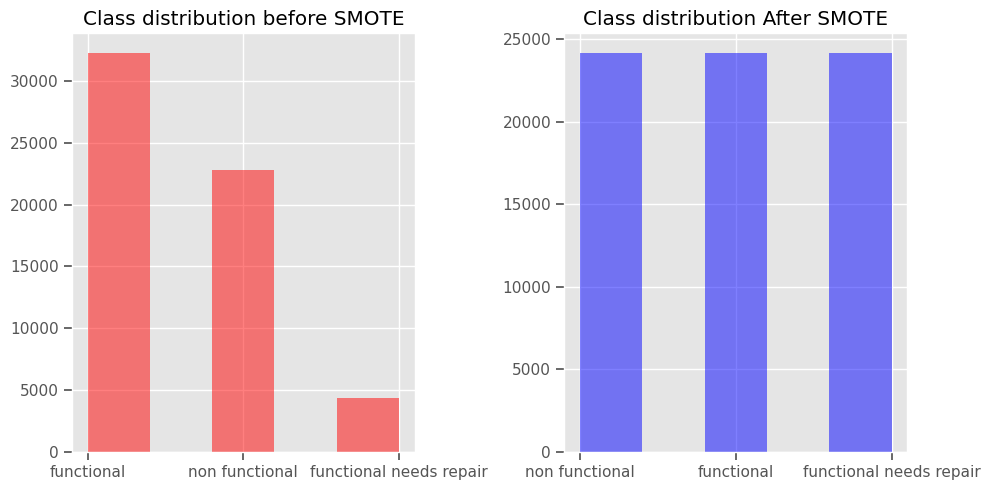

In [38]:
sns.set_context("notebook")
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5)) 
ax1.hist(y, color = 'red', alpha = .5, bins = 5)
ax1.set_title('Class distribution before SMOTE')
ax2.hist(y_train_res, color = 'blue', alpha = .5, bins = 5)
ax2.set_title('Class distribution After SMOTE')
fig.tight_layout();

#### Model After Smote

In [39]:
lr2 = LogisticRegression(max_iter=1000, random_state = 42)
lr2.fit(X_train_res, y_train_res)

LogisticRegression(max_iter=1000, random_state=42)

In [40]:
# Score on our training data
y_pred = lr2.predict(X_train_res)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.65      0.64      0.65     24161
functional needs repair       0.65      0.74      0.69     24161
         non functional       0.76      0.66      0.70     24161

               accuracy                           0.68     72483
              macro avg       0.68      0.68      0.68     72483
           weighted avg       0.68      0.68      0.68     72483



In [41]:
# Score on our testing data
y_pred = lr2.predict(X_test_fin)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.63      0.70      8098
functional needs repair       0.21      0.72      0.32      1074
         non functional       0.77      0.65      0.70      5678

               accuracy                           0.64     14850
              macro avg       0.59      0.66      0.58     14850
           weighted avg       0.75      0.64      0.68     14850



Our accuracy is now more even across classes, especially on the training data. However on the testing data, while the recall score soared, the precision score plummeted? The f1 score is still not great on the testing data either but really improved on the training data for class "functional needs repair". Considering our model is working much better on our training data than our testing data, we could use regularization techniques to avoid overfitting.

#### Dealing with Multicollinearity
Some investigators use correlation coefficients cutoffs of 0.5 and above but most typical cutoff is 0.80

In [42]:
X_train_res, y_train_res, X_test_fin, y_test

(       amount_tsh  gps_height  longitude  latitude  num_private  region_code  \
 0       -0.093074   -0.487869   0.616411 -0.129019    -0.037802    -0.529321   
 1       -0.099150   -0.964042  -5.221778  1.940133    -0.037802     0.092290   
 2       -0.099150   -0.964042  -0.120413  0.983559    -0.037802     0.205310   
 3       -0.099150    1.260983   0.104811  0.294199    -0.037802    -0.133751   
 4       -0.099150   -0.209380   0.086112 -1.699526    -0.037802    -0.303281   
 ...           ...         ...        ...       ...          ...          ...   
 72478   -0.099150   -0.964042  -0.256932  1.078087    -0.037802     0.205310   
 72479   -0.099150   -0.808335   0.660527 -0.321397    -0.037802    -0.529321   
 72480   -0.099150   -0.964042  -5.221778  1.940133    -0.037802     0.205310   
 72481   -0.099150   -0.462975   0.700226 -1.764289    -0.037802     4.217521   
 72482   -0.099150   -0.964042  -0.123627  0.648767    -0.037802     0.092290   
 
        district_code  pop

In [43]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(X_train_res, 3))

Top Absolute Correlations
management_unknown        management_group_unknown              1.0
extraction_type_windmill  extraction_type_class_wind-powered    1.0
extraction_type_gravity   extraction_type_group_gravity         1.0
dtype: float64


In [44]:
top_corrs = get_top_abs_correlations(X_train_res, 75) #Threshhold correlation for cut off is .75

In [45]:
features_to_drop = [pair[1] for pair in top_corrs.index]

In [46]:
len(features_to_drop)

75

In [47]:
# Remove Duplicates from list
features_to_drop = list(dict.fromkeys(features_to_drop))
len(features_to_drop)

58

In [48]:
X_train_res.shape

(72483, 291)

In [49]:
X_train_res.drop(features_to_drop, axis=1, inplace=True)

In [50]:
X_train_res.shape

(72483, 233)

In [51]:
X_test_fin.shape

(14850, 291)

In [52]:
X_test_fin.drop(features_to_drop, axis=1, inplace=True)

In [53]:
X_test_fin.shape

(14850, 233)

In [54]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(X_train_res, 3))

Top Absolute Correlations
basin_Lake Tanganyika  region_Kigoma         0.735790
longitude              lga_Bariadi           0.734270
water_quality_salty    water_quality_soft    0.727066
dtype: float64


#### Feature Selection

In [55]:
#use inbuilt class feature_importances of tree based classifiers
model = ExtraTreesClassifier()
model.fit(X_train_res,y_train_res)

ExtraTreesClassifier()

In [56]:
# print(model.feature_importances_) 
feature_importance_df = pd.DataFrame(model.feature_importances_, index=X_train_res.columns).sort_values(by = 0, ascending = False)
feature_importance_df.head(10)

0
longitude              0.116476
latitude               0.114816
gps_height             0.053869
quantity_dry           0.053694
construction_year      0.043943
population             0.039656
quantity_enough        0.024825
waterpoint_type_other  0.020367
quantity_insufficient  0.018995
payment_never pay      0.017120

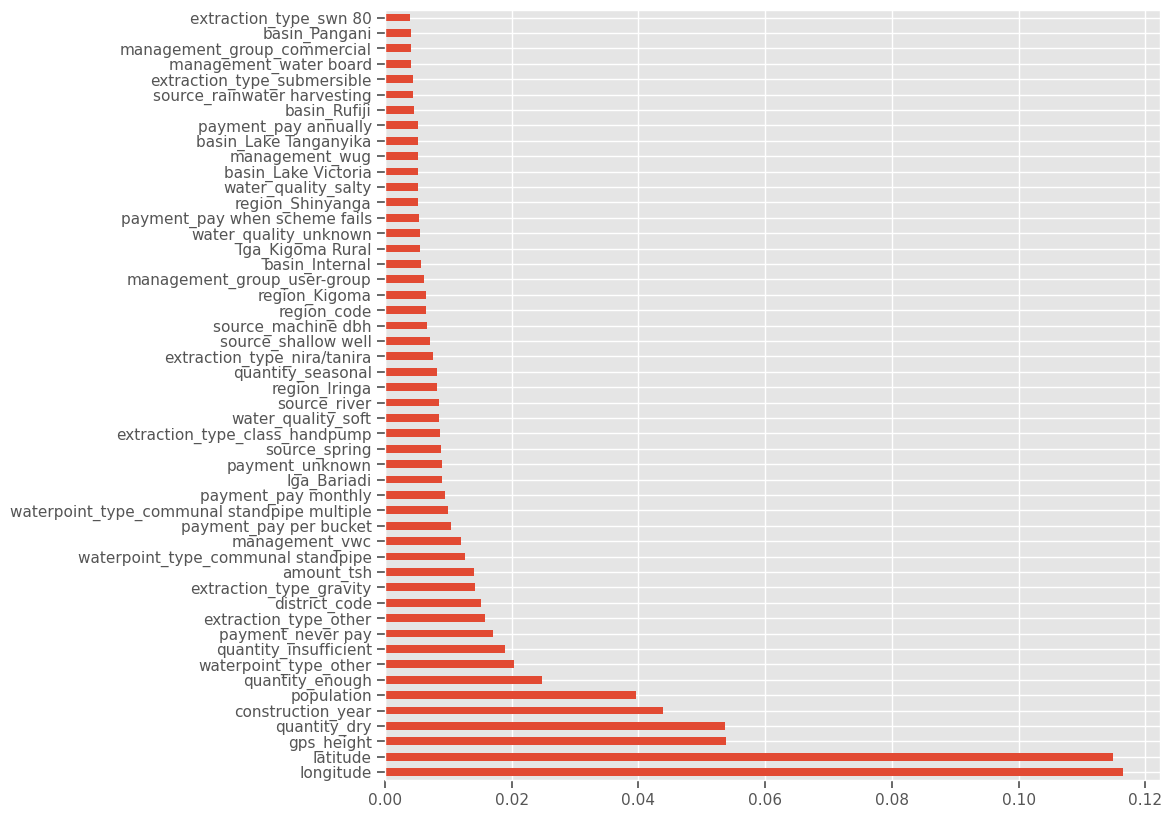

In [57]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train_res.columns)
fig = plt.subplots(figsize = (10,10))
feat_importances.nlargest(50).plot(kind='barh')
plt.show();

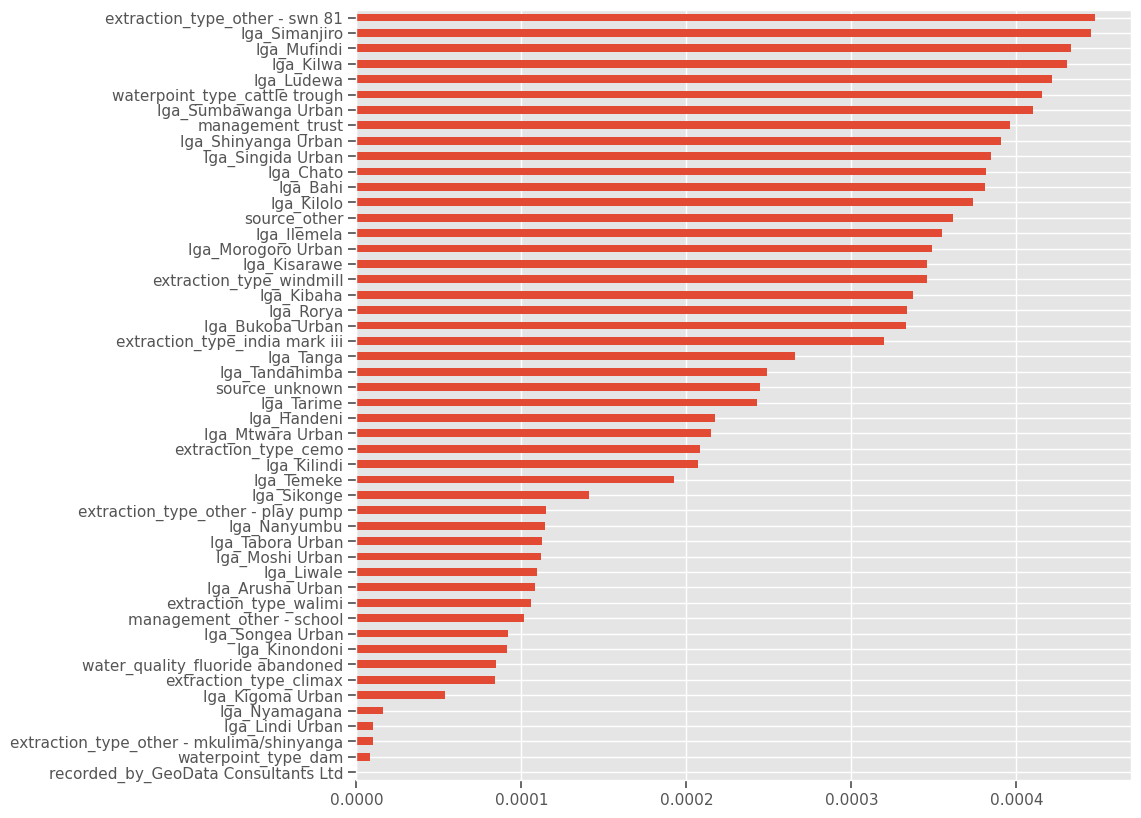

In [58]:
fig = plt.subplots(figsize = (10,10))
feat_importances.nsmallest(50).plot(kind='barh');


#### Filtered feature selection

In [59]:
print('Feature count: ', X_train_res.shape[1])

Feature count:  233


In [60]:
# Filter training and testing data with 233 largest features
X_train_filt = X_train_res[feat_importances.nlargest(233).index]
X_test_filt = X_test_fin[feat_importances.nlargest(233).index]

In [61]:
print('Feature count: ', X_train_filt.shape[1])

Feature count:  233


### Modeling with our Refined Data

Using hyperparameters from Andrew's tuning

In [62]:
# X_train_filt
# y_train_res
# X_test_filt
# y_test

#### Logistic Regression

In [63]:
lr3 = LogisticRegression(max_iter=1000, random_state = 42)
lr3.fit(X_train_filt, y_train_res)

LogisticRegression(max_iter=1000, random_state=42)

In [64]:
# Score on our training data
y_pred = lr3.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.65      0.64      0.64     24161
functional needs repair       0.65      0.74      0.69     24161
         non functional       0.76      0.66      0.70     24161

               accuracy                           0.68     72483
              macro avg       0.68      0.68      0.68     72483
           weighted avg       0.68      0.68      0.68     72483



In [65]:
# Score on our testing data
y_pred = lr3.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.63      0.70      8098
functional needs repair       0.21      0.72      0.32      1074
         non functional       0.77      0.65      0.70      5678

               accuracy                           0.64     14850
              macro avg       0.59      0.66      0.58     14850
           weighted avg       0.75      0.64      0.68     14850



#### KNN

In [66]:
knn1 = KNeighborsClassifier(3)
knn1.fit(X_train_filt, y_train_res)

KNeighborsClassifier(n_neighbors=3)

In [67]:
# Score on our training data
y_pred = knn1.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.88      0.87      0.87     24161
functional needs repair       0.91      0.96      0.93     24161
         non functional       0.92      0.90      0.91     24161

               accuracy                           0.91     72483
              macro avg       0.91      0.91      0.91     72483
           weighted avg       0.91      0.91      0.91     72483



In [68]:
# Score on our testing data
y_pred = knn1.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.75      0.78      8098
functional needs repair       0.31      0.53      0.39      1074
         non functional       0.77      0.75      0.76      5678

               accuracy                           0.73     14850
              macro avg       0.63      0.67      0.64     14850
           weighted avg       0.76      0.73      0.74     14850



#### Decision Tree

In [69]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_filt, y_train_res)

DecisionTreeClassifier(random_state=42)

In [70]:
# Score on our training data
y_pred = dt.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       1.00      0.99      0.99     24161
functional needs repair       0.99      1.00      0.99     24161
         non functional       1.00      1.00      1.00     24161

               accuracy                           1.00     72483
              macro avg       1.00      1.00      1.00     72483
           weighted avg       1.00      1.00      1.00     72483



In [71]:
# Score on our testing data
y_pred = dt.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.77      0.78      8098
functional needs repair       0.34      0.47      0.39      1074
         non functional       0.76      0.76      0.76      5678

               accuracy                           0.74     14850
              macro avg       0.63      0.66      0.65     14850
           weighted avg       0.75      0.74      0.75     14850



#### SVC

In [72]:
# svm = SVC(kernel='linear', decision_function_shape='ovo', random_state=42)
# svm.fit(X_train_filt, y_train_res)

In [73]:
# # Score on our training data
# y_pred = svm.predict(X_train_filt)
# print(classification_report(y_train_res, y_pred))

In [74]:
# # Score on our testing data
# y_pred = svm.predict(X_test_filt)
# print(classification_report(y_test, y_pred))

## Ensemble Methods

Voting and Averaging are "weak" estimators. They are useful in the case that the models are already accurate

#### VotingClassifier

In [75]:
#Base estimators
# lr3 - linear regression model
# knn1 - knn model
# dt - decision tree model
# etc - extra trees classifier model

clf_voting = VotingClassifier(
    estimators = [
        ('linear regression', lr3),
        ('K Nearest Neighbors', knn1),
        ('Decision Tree', dt)])

In [76]:
clf_voting.fit(X_train_filt, y_train_res)

VotingClassifier(estimators=[('linear regression',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('K Nearest Neighbors',
                              KNeighborsClassifier(n_neighbors=3)),
                             ('Decision Tree',
                              DecisionTreeClassifier(random_state=42))])

In [77]:
# Score on our training data
y_pred = clf_voting.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.92      0.93      0.92     24161
functional needs repair       0.94      0.98      0.96     24161
         non functional       0.97      0.92      0.94     24161

               accuracy                           0.94     72483
              macro avg       0.94      0.94      0.94     72483
           weighted avg       0.94      0.94      0.94     72483



In [78]:
# Score on our testing data
y_pred = clf_voting.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.79      0.80      8098
functional needs repair       0.34      0.55      0.42      1074
         non functional       0.82      0.74      0.78      5678

               accuracy                           0.76     14850
              macro avg       0.65      0.70      0.67     14850
           weighted avg       0.78      0.76      0.77     14850



#### Averaging Classifier

In [79]:
#Base estimators
# lr3 - linear regression model
# knn1 - knn model
# dt - decision tree model
# etc - extra trees classifier model

clf_averaging = VotingClassifier(
    estimators = [
        ('linear regression', lr3),
        ('K Nearest Neighbors', knn1),
        ('Decision Tree', dt)],
    voting = 'soft',
)
clf_averaging.fit(X_train_filt, y_train_res)

VotingClassifier(estimators=[('linear regression',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('K Nearest Neighbors',
                              KNeighborsClassifier(n_neighbors=3)),
                             ('Decision Tree',
                              DecisionTreeClassifier(random_state=42))],
                 voting='soft')

In [80]:
# Score on our training data
y_pred = clf_averaging.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.99      0.98      0.98     24161
functional needs repair       0.98      0.99      0.99     24161
         non functional       0.99      0.99      0.99     24161

               accuracy                           0.99     72483
              macro avg       0.99      0.99      0.99     72483
           weighted avg       0.99      0.99      0.99     72483



In [81]:
# Score on our testing data
y_pred = clf_averaging.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.79      0.80      8098
functional needs repair       0.35      0.53      0.42      1074
         non functional       0.80      0.76      0.78      5678

               accuracy                           0.76     14850
              macro avg       0.66      0.69      0.67     14850
           weighted avg       0.78      0.76      0.77     14850



#### Extra Trees Classifier

In [82]:
# etc = ExtraTreesClassifier()
# etc.fit(X_train_filt,y_train_res)

In [83]:
# # Score on our training data
# y_pred = etc.predict(X_train_filt)
# print(classification_report(y_train_res, y_pred))

In [84]:
# # Score on our testing data
# y_pred = etc.predict(X_test_filt)
# print(classification_report(y_test, y_pred))

#### Random Forest Classifier

In [85]:
rfc = RandomForestClassifier(max_depth=10, n_estimators=2000, random_state=42)
rfc.fit(X_train_filt,y_train_res)

RandomForestClassifier(max_depth=10, n_estimators=2000, random_state=42)

In [86]:
# Score on our training data
y_pred = rfc.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.68      0.75      0.71     24161
functional needs repair       0.72      0.82      0.77     24161
         non functional       0.87      0.66      0.75     24161

               accuracy                           0.74     72483
              macro avg       0.76      0.74      0.74     72483
           weighted avg       0.76      0.74      0.74     72483



In [87]:
# Score on our testing data
y_pred = rfc.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.78      0.72      0.75      8098
functional needs repair       0.22      0.64      0.33      1074
         non functional       0.84      0.64      0.72      5678

               accuracy                           0.68     14850
              macro avg       0.61      0.67      0.60     14850
           weighted avg       0.76      0.68      0.71     14850



#### Bagging Classifier Random Forest

Note Bagging is computationally expensive as it uses cross validation and will take time to run

For classification, the optimal value of max_features lies around the square root of the number of features. The square root of 250 is 15.8.

In [88]:
# # Setting max_features to 35 after some trial and error. The square root of number of features didnt seem to work well
# b_rf_clf = BaggingClassifier(RandomForestClassifier(max_depth=26), n_estimators = 30, max_features=35, random_state=42)
# b_rf_clf.fit(X_train_filt,y_train_res)

In [89]:
# # Score on our training data
# y_pred = b_rf_clf.predict(X_train_filt)
# print(classification_report(y_train_res, y_pred))

In [90]:
# # Score on our testing data
# y_pred = b_rf_clf.predict(X_test_filt)
# print(classification_report(y_test, y_pred))

GridSearch on Bagging Classifier

In [91]:
# grid = {"max_samples": [0.5, 1.0],
#         "bootstrap": [True, False],
#         "bootstrap_features": [True, False]}

# b_rf_clf = GridSearchCV(BaggingClassifier(RandomForestClassifier(max_depth=25), n_estimators = 10, max_features = 35),
#                         param_grid = grid)

Do not run the following cells again, takes a very long time and best params are just the default -_-

In [92]:
# b_rf_clf.fit(X_train_filt,y_train_res)

In [93]:
# b_rf_clf.best_params_
# 'bootstrap': True, 'bootstrap_features': False, 'max_samples': 1.0

### Boosting Algorithms
Based on iterative learning and sequential model building.
Good choice when problems are complex, need to apply parallel processing, have big data sets

#### Ada Boost Classifier

In [94]:
# Instantiate an AdaBoostClassifier
# Defaults are estimator=DecisionTree, n_estimator=100, learning_rate = 1
adaboost_clf = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_clf.fit(X_train_filt, y_train_res)

AdaBoostClassifier(n_estimators=100, random_state=42)

In [95]:
# Score on our training data
y_pred = adaboost_clf.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.65      0.64      0.65     24161
functional needs repair       0.65      0.76      0.70     24161
         non functional       0.76      0.63      0.69     24161

               accuracy                           0.68     72483
              macro avg       0.68      0.68      0.68     72483
           weighted avg       0.68      0.68      0.68     72483



In [96]:
# Score on our testing data
y_pred = adaboost_clf.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.79      0.63      0.70      8098
functional needs repair       0.19      0.66      0.29      1074
         non functional       0.78      0.63      0.70      5678

               accuracy                           0.63     14850
              macro avg       0.58      0.64      0.56     14850
           weighted avg       0.74      0.63      0.67     14850



#### Gradient Boosting Classifier

In [97]:
# Instantiate an GradientBoostingClassifier
# We dont specify an estimator since Gradient Boosting uses regression trees
# Default params: n_estimators=100, learning_rate=0.1, mex_depth=3, min_samples_split, min_samples_leaf, max_features
# In Gradient Boosting, it is recommended to use all the features
gbt_clf = GradientBoostingClassifier(random_state=42)
gbt_clf.fit(X_train_filt, y_train_res)

GradientBoostingClassifier(random_state=42)

In [98]:
# Score on our training data
y_pred = gbt_clf.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.67      0.74      0.70     24161
functional needs repair       0.72      0.79      0.75     24161
         non functional       0.82      0.65      0.72     24161

               accuracy                           0.73     72483
              macro avg       0.74      0.73      0.73     72483
           weighted avg       0.74      0.73      0.73     72483



In [99]:
# Score on our testing data
y_pred = gbt_clf.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.78      0.72      0.75      8098
functional needs repair       0.23      0.61      0.33      1074
         non functional       0.82      0.63      0.71      5678

               accuracy                           0.68     14850
              macro avg       0.61      0.66      0.60     14850
           weighted avg       0.75      0.68      0.70     14850



#### Extreme Gradient Boosting Classifier

Optomized for distributed computing. Parallel training.

In [100]:
xgbc = xgb.XGBClassifier(max_depth=10, random_state=42)
xgbc.fit(X_train_filt,y_train_res)

XGBClassifier(max_depth=10, objective='multi:softprob', random_state=42)

In [101]:
# Score on our training data
y_pred = xgbc.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.83      0.82     24161
functional needs repair       0.84      0.93      0.88     24161
         non functional       0.91      0.80      0.85     24161

               accuracy                           0.85     72483
              macro avg       0.86      0.85      0.85     72483
           weighted avg       0.86      0.85      0.85     72483



In [102]:
# Score on our testing data
y_pred = xgbc.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.78      0.80      8098
functional needs repair       0.30      0.62      0.41      1074
         non functional       0.84      0.73      0.78      5678

               accuracy                           0.75     14850
              macro avg       0.65      0.71      0.66     14850
           weighted avg       0.79      0.75      0.76     14850



#### Light Gradient Boosting

Released by Microsoft in 2017
Fast and efficient. Lighter in terms of space.
Optimized for parallel and GPU processing.
Useful for big datasets.

In [103]:
# Params similar to gradient boosting except default max_depth = -1 (unlimited)
clf_lgb = lgb.LGBMClassifier(n_estimators=1000, seed=42)
clf_lgb.fit(X_train_filt,y_train_res)

LGBMClassifier(n_estimators=1000, seed=42)

In [104]:
# Score on our training data
y_pred = clf_lgb.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.89      0.90      0.90     24161
functional needs repair       0.92      0.96      0.94     24161
         non functional       0.95      0.89      0.92     24161

               accuracy                           0.92     72483
              macro avg       0.92      0.92      0.92     72483
           weighted avg       0.92      0.92      0.92     72483



In [105]:
# Score on our testing data
y_pred = clf_lgb.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.83      0.82      0.82      8098
functional needs repair       0.38      0.52      0.44      1074
         non functional       0.82      0.78      0.80      5678

               accuracy                           0.78     14850
              macro avg       0.68      0.71      0.69     14850
           weighted avg       0.79      0.78      0.79     14850



#### Cat Boost
Open sourced by Yandex(april 2017). Built in handling of categorical features. Accurate and robust. Fast and scalable

In [106]:
# Default Params - n_estimators=1000, learning_rate=0.1, max_depth=3, 
reg_cat = cb.CatBoostClassifier(random_state=500)
reg_cat.fit(X_train_filt, y_train_res)

Learning rate set to 0.098445
0:	learn: 1.0605590	total: 209ms	remaining: 3m 28s
1:	learn: 1.0300504	total: 269ms	remaining: 2m 14s
2:	learn: 1.0057098	total: 325ms	remaining: 1m 48s
3:	learn: 0.9859632	total: 381ms	remaining: 1m 34s
4:	learn: 0.9684210	total: 438ms	remaining: 1m 27s
5:	learn: 0.9521878	total: 496ms	remaining: 1m 22s
6:	learn: 0.9385347	total: 551ms	remaining: 1m 18s
7:	learn: 0.9264377	total: 610ms	remaining: 1m 15s
8:	learn: 0.9150362	total: 673ms	remaining: 1m 14s
9:	learn: 0.9063570	total: 730ms	remaining: 1m 12s
10:	learn: 0.8973807	total: 785ms	remaining: 1m 10s
11:	learn: 0.8906336	total: 845ms	remaining: 1m 9s
12:	learn: 0.8822345	total: 906ms	remaining: 1m 8s
13:	learn: 0.8750347	total: 962ms	remaining: 1m 7s
14:	learn: 0.8687482	total: 1.02s	remaining: 1m 6s
15:	learn: 0.8632528	total: 1.07s	remaining: 1m 6s
16:	learn: 0.8563120	total: 1.14s	remaining: 1m 6s
17:	learn: 0.8505408	total: 1.21s	remaining: 1m 5s
18:	learn: 0.8461732	total: 1.26s	remaining: 1m 5s


163:	learn: 0.6293616	total: 9.27s	remaining: 47.3s
164:	learn: 0.6285107	total: 9.32s	remaining: 47.2s
165:	learn: 0.6277025	total: 9.37s	remaining: 47.1s
166:	learn: 0.6270178	total: 9.43s	remaining: 47.1s
167:	learn: 0.6260957	total: 9.49s	remaining: 47s
168:	learn: 0.6254565	total: 9.55s	remaining: 46.9s
169:	learn: 0.6246910	total: 9.6s	remaining: 46.9s
170:	learn: 0.6240795	total: 9.65s	remaining: 46.8s
171:	learn: 0.6235240	total: 9.71s	remaining: 46.7s
172:	learn: 0.6226697	total: 9.76s	remaining: 46.7s
173:	learn: 0.6219562	total: 9.82s	remaining: 46.6s
174:	learn: 0.6215352	total: 9.87s	remaining: 46.5s
175:	learn: 0.6209845	total: 9.93s	remaining: 46.5s
176:	learn: 0.6204716	total: 9.97s	remaining: 46.4s
177:	learn: 0.6197082	total: 10s	remaining: 46.3s
178:	learn: 0.6189665	total: 10.1s	remaining: 46.3s
179:	learn: 0.6183872	total: 10.1s	remaining: 46.2s
180:	learn: 0.6178531	total: 10.2s	remaining: 46.1s
181:	learn: 0.6167527	total: 10.2s	remaining: 46.1s
182:	learn: 0.616

326:	learn: 0.5510344	total: 18.2s	remaining: 37.5s
327:	learn: 0.5506059	total: 18.3s	remaining: 37.4s
328:	learn: 0.5503780	total: 18.3s	remaining: 37.3s
329:	learn: 0.5501362	total: 18.4s	remaining: 37.3s
330:	learn: 0.5498911	total: 18.4s	remaining: 37.2s
331:	learn: 0.5496758	total: 18.5s	remaining: 37.2s
332:	learn: 0.5495085	total: 18.5s	remaining: 37.1s
333:	learn: 0.5491108	total: 18.6s	remaining: 37s
334:	learn: 0.5488038	total: 18.6s	remaining: 37s
335:	learn: 0.5484400	total: 18.7s	remaining: 36.9s
336:	learn: 0.5480186	total: 18.7s	remaining: 36.9s
337:	learn: 0.5475522	total: 18.8s	remaining: 36.8s
338:	learn: 0.5472094	total: 18.8s	remaining: 36.7s
339:	learn: 0.5468637	total: 18.9s	remaining: 36.7s
340:	learn: 0.5465575	total: 19s	remaining: 36.6s
341:	learn: 0.5461943	total: 19s	remaining: 36.6s
342:	learn: 0.5459170	total: 19.1s	remaining: 36.5s
343:	learn: 0.5455266	total: 19.1s	remaining: 36.5s
344:	learn: 0.5452690	total: 19.2s	remaining: 36.4s
345:	learn: 0.545033

485:	learn: 0.5090632	total: 26.8s	remaining: 28.4s
486:	learn: 0.5089237	total: 26.9s	remaining: 28.3s
487:	learn: 0.5087012	total: 26.9s	remaining: 28.2s
488:	learn: 0.5085277	total: 27s	remaining: 28.2s
489:	learn: 0.5082815	total: 27s	remaining: 28.1s
490:	learn: 0.5080593	total: 27.1s	remaining: 28.1s
491:	learn: 0.5078970	total: 27.1s	remaining: 28s
492:	learn: 0.5077308	total: 27.2s	remaining: 28s
493:	learn: 0.5075108	total: 27.3s	remaining: 27.9s
494:	learn: 0.5073226	total: 27.3s	remaining: 27.9s
495:	learn: 0.5071695	total: 27.4s	remaining: 27.8s
496:	learn: 0.5069785	total: 27.4s	remaining: 27.8s
497:	learn: 0.5068528	total: 27.5s	remaining: 27.7s
498:	learn: 0.5066255	total: 27.5s	remaining: 27.7s
499:	learn: 0.5064652	total: 27.6s	remaining: 27.6s
500:	learn: 0.5062417	total: 27.6s	remaining: 27.5s
501:	learn: 0.5061231	total: 27.7s	remaining: 27.5s
502:	learn: 0.5060002	total: 27.7s	remaining: 27.4s
503:	learn: 0.5057550	total: 27.8s	remaining: 27.4s
504:	learn: 0.505606

644:	learn: 0.4813666	total: 35.5s	remaining: 19.5s
645:	learn: 0.4812739	total: 35.5s	remaining: 19.5s
646:	learn: 0.4810415	total: 35.6s	remaining: 19.4s
647:	learn: 0.4809100	total: 35.6s	remaining: 19.4s
648:	learn: 0.4808150	total: 35.7s	remaining: 19.3s
649:	learn: 0.4806709	total: 35.7s	remaining: 19.2s
650:	learn: 0.4805655	total: 35.8s	remaining: 19.2s
651:	learn: 0.4804882	total: 35.8s	remaining: 19.1s
652:	learn: 0.4803040	total: 35.9s	remaining: 19.1s
653:	learn: 0.4801669	total: 36s	remaining: 19s
654:	learn: 0.4800285	total: 36s	remaining: 19s
655:	learn: 0.4798767	total: 36.1s	remaining: 18.9s
656:	learn: 0.4796761	total: 36.1s	remaining: 18.9s
657:	learn: 0.4796014	total: 36.2s	remaining: 18.8s
658:	learn: 0.4794143	total: 36.2s	remaining: 18.7s
659:	learn: 0.4792732	total: 36.3s	remaining: 18.7s
660:	learn: 0.4789755	total: 36.3s	remaining: 18.6s
661:	learn: 0.4788313	total: 36.4s	remaining: 18.6s
662:	learn: 0.4786940	total: 36.4s	remaining: 18.5s
663:	learn: 0.478527

803:	learn: 0.4601992	total: 44.1s	remaining: 10.8s
804:	learn: 0.4600941	total: 44.2s	remaining: 10.7s
805:	learn: 0.4600212	total: 44.3s	remaining: 10.7s
806:	learn: 0.4599023	total: 44.3s	remaining: 10.6s
807:	learn: 0.4596872	total: 44.4s	remaining: 10.5s
808:	learn: 0.4594475	total: 44.4s	remaining: 10.5s
809:	learn: 0.4592849	total: 44.5s	remaining: 10.4s
810:	learn: 0.4591627	total: 44.5s	remaining: 10.4s
811:	learn: 0.4589996	total: 44.6s	remaining: 10.3s
812:	learn: 0.4588692	total: 44.6s	remaining: 10.3s
813:	learn: 0.4586669	total: 44.7s	remaining: 10.2s
814:	learn: 0.4585541	total: 44.8s	remaining: 10.2s
815:	learn: 0.4584701	total: 44.8s	remaining: 10.1s
816:	learn: 0.4583229	total: 44.9s	remaining: 10.1s
817:	learn: 0.4581549	total: 44.9s	remaining: 10s
818:	learn: 0.4580864	total: 45s	remaining: 9.94s
819:	learn: 0.4580359	total: 45s	remaining: 9.89s
820:	learn: 0.4578864	total: 45.1s	remaining: 9.83s
821:	learn: 0.4577378	total: 45.1s	remaining: 9.78s
822:	learn: 0.4576

962:	learn: 0.4426322	total: 52.9s	remaining: 2.03s
963:	learn: 0.4424780	total: 52.9s	remaining: 1.98s
964:	learn: 0.4423741	total: 53s	remaining: 1.92s
965:	learn: 0.4423062	total: 53s	remaining: 1.87s
966:	learn: 0.4421419	total: 53.1s	remaining: 1.81s
967:	learn: 0.4421246	total: 53.1s	remaining: 1.76s
968:	learn: 0.4419828	total: 53.2s	remaining: 1.7s
969:	learn: 0.4418776	total: 53.2s	remaining: 1.65s
970:	learn: 0.4417670	total: 53.3s	remaining: 1.59s
971:	learn: 0.4416546	total: 53.4s	remaining: 1.54s
972:	learn: 0.4415138	total: 53.4s	remaining: 1.48s
973:	learn: 0.4414334	total: 53.5s	remaining: 1.43s
974:	learn: 0.4413137	total: 53.5s	remaining: 1.37s
975:	learn: 0.4412229	total: 53.6s	remaining: 1.32s
976:	learn: 0.4411245	total: 53.6s	remaining: 1.26s
977:	learn: 0.4410243	total: 53.7s	remaining: 1.21s
978:	learn: 0.4409805	total: 53.7s	remaining: 1.15s
979:	learn: 0.4408861	total: 53.8s	remaining: 1.1s
980:	learn: 0.4408198	total: 53.8s	remaining: 1.04s
981:	learn: 0.4407

In [107]:
# Score on our training data
y_pred = reg_cat.predict(X_train_filt)
print(classification_report(y_train_res, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.81      0.80     24161
functional needs repair       0.84      0.91      0.87     24161
         non functional       0.88      0.79      0.83     24161

               accuracy                           0.84     72483
              macro avg       0.84      0.84      0.84     72483
           weighted avg       0.84      0.84      0.84     72483



In [108]:
# Score on our testing data
y_pred = reg_cat.predict(X_test_filt)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

             functional       0.82      0.78      0.80      8098
functional needs repair       0.32      0.59      0.41      1074
         non functional       0.83      0.75      0.78      5678

               accuracy                           0.75     14850
              macro avg       0.65      0.71      0.67     14850
           weighted avg       0.79      0.75      0.77     14850



### Stacking

Combining models together. Good choice when Voting/Averaging dont have great results

In [109]:
# Parameters = classifiers = [clf1, clf2, clf3...], meta_classifiers=clf_meta, use_probas=False, use_features_in_secondary=False

clf_dt = DecisionTreeClassifier(random_state=42)
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_lr = LogisticRegression(max_iter=1000, random_state=42)

classifiers = [clf_dt, clf_knn, clf_lr]

clf_meta = DecisionTreeClassifier(random_state=42)

clf_stack = StackingClassifier(classifiers, clf_meta, use_features_in_secondary=True)

Target classes need to be numerical for StackingClassifier to work. Use Label Encoder for this

In [110]:
le = LabelEncoder()
le.fit(y_train_res)

LabelEncoder()

In [111]:
y_train_le = le.fit_transform(y_train_res)
y_test_le = le.transform(y_test)

In [112]:
clf_stack.fit(X_train_filt, y_train_le)

StackingClassifier(classifiers=[DecisionTreeClassifier(random_state=42),
                                KNeighborsClassifier(),
                                LogisticRegression(max_iter=1000,
                                                   random_state=42)],
                   meta_classifier=DecisionTreeClassifier(random_state=42),
                   use_features_in_secondary=True)

In [113]:
# Score on our training data
y_pred = clf_stack.predict(X_train_filt)
print(classification_report(y_train_le, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     24161
           1       0.99      1.00      0.99     24161
           2       1.00      1.00      1.00     24161

    accuracy                           1.00     72483
   macro avg       1.00      1.00      1.00     72483
weighted avg       1.00      1.00      1.00     72483



In [114]:
# Score on our testing data
y_pred = clf_stack.predict(X_test_filt)
print(classification_report(y_test_le, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.77      0.78      8098
           1       0.34      0.47      0.39      1074
           2       0.76      0.76      0.76      5678

    accuracy                           0.74     14850
   macro avg       0.63      0.66      0.65     14850
weighted avg       0.75      0.74      0.75     14850



#### Where to go from here

those columns with the null values

Looks like we still have some overfitting so think of reducing features

tuning hyper parameters

pipelines?